In [2]:
from backtesting.test import SMA
from backtesting import Strategy
from backtesting.lib import crossover


class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)

    def next(self):

        if not self.position:

            # On upwards trend, if price closes above
            # "entry" MA, go long

            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()

            # On downwards trend, if price closes below
            # "entry" MA, go short

            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()

        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position

        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):

                self.position.close()

In [3]:

from backtesting import Backtest
from backtesting.test import GOOG


backtest = Backtest(GOOG, Sma4Cross, commission=.002)

stats, heatmap = backtest.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

In [5]:
heatmap

n1   n2   n_enter  n_exit
20   60   15       10        10102.86700
     80   15       10         9864.21924
     100  15       10        11003.21764
30   40   20       15        11771.28610
          25       15        16178.54842
                                ...     
100  200  15       10        13118.24766
          20       10        11308.46180
                   15        16350.94380
          25       10         8991.55294
          30       10         9953.07010
Name: Equity Final [$], Length: 177, dtype: float64

In [9]:
stats_skopt, heatmap, optimize_result = backtest.optimize(
    n1=[10, 100],      # Note: For method="skopt", we
    n2=[20, 200],      # only need interval end-points
    n_enter=[10, 40],
    n_exit=[10, 30],
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=200,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

heatmap.sort_values().iloc[-3:]

n1  n2   n_enter  n_exit
35  98   28       24        28365.14512
68  96   29       24        28424.01724
44  134  39       27        29941.37700
Name: Equity Final [$], dtype: float64

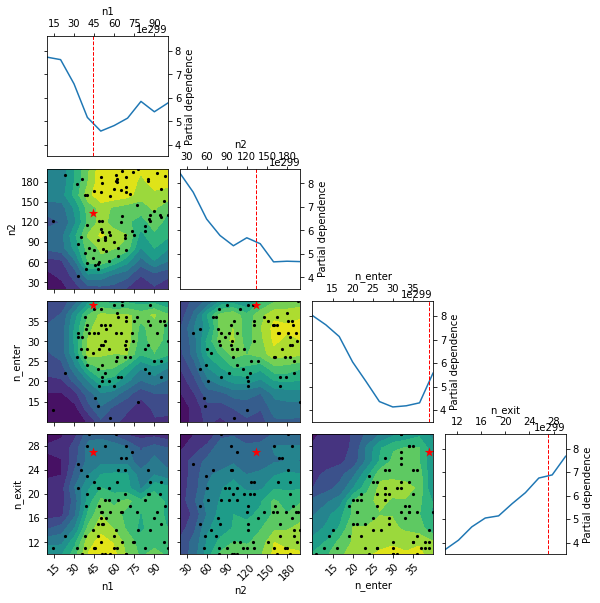

In [10]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

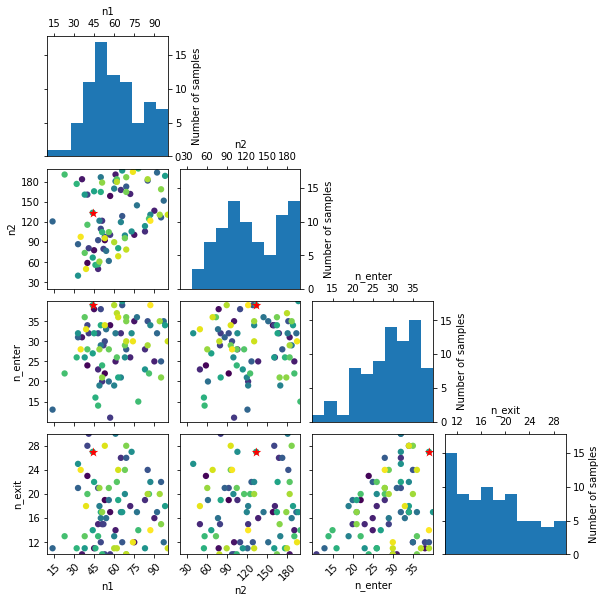

In [11]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

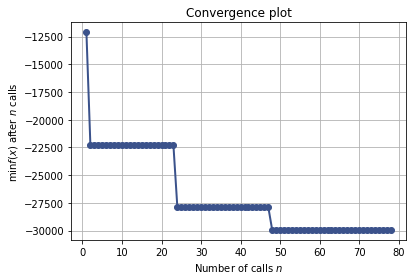

In [13]:
from skopt.plots import plot_convergence

plot_convergence(optimize_result, bins=10);

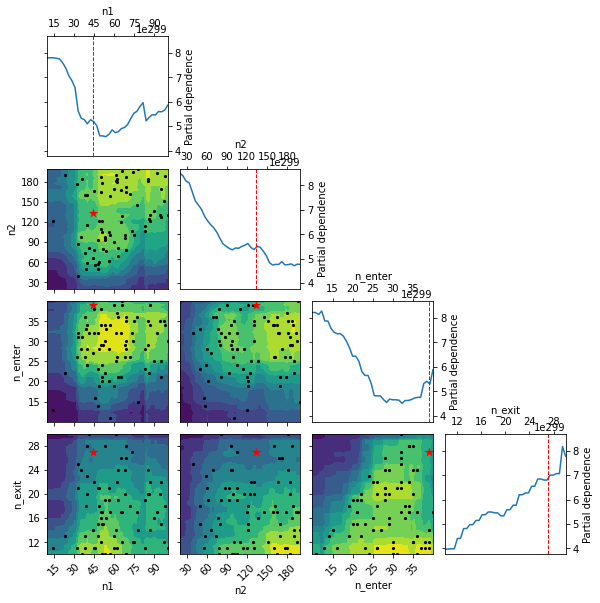

In [15]:
from skopt.plots import plot_objective

plot_objective(optimize_result);

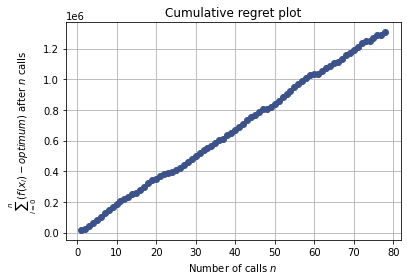

In [16]:
from skopt.plots import plot_regret

plot_regret(optimize_result);